TODO Jack:


*   scaricato il dataset, si dovrebbe prendere test, train, val ed univerli "normal-penuomia", fare lo shuffle e creare le coppie immagini-label -> creare un'altra director "chest_ray_shuffled con "test, train, val". Come label si potrebbe semplicemente rinominare l'immagine come \<label\>\_\<test/train/val\>\<numeric_id\>. esempio normale_test_00001
*   eliminare il vecchio "chest_ray" directory che contiene le immagini non mischiate ( per motivi di memoria ). con `! rm -rf /content/chest_ray`
*   provare a creare l'oggetto dataset "ChestRay_DataModule"
*   provare a creare l'oggetto architettura "JAM"
*   vedere se una immagine ed un batch viene parsata dalla rete


TODO Max:
* Effettuare vari preprocessing (data augmentation, he, he + gaussian blur, heatmap, downsampling)
* Scegliere una colormap per la [heatmap](https://www.shutterstock.com/image-vector/heat-map-abstract-infrared-thermographic-260nw-2239656403.jpg) , ce ne sono varie, alcune fanno "peggio" ed altre vanno bene. Oppure scegliere un preprocessing in generale.




# INSTALLATION

In this section there are the installation needed for the rest of the code:

1. *gdown* : This package is used for downloading files from Google Drive. It's handy for fetching data or models stored on Google Drive links.

2. *tqdm* : This package provides a progress bar for iterables (like loops or file downloads) in Python. It makes it easier to track the progress of lengthy operations.

3. *pytorch_ligthning* : This is a high-level interface for PyTorch that makes it easier to train complex models. It provides abstractions and utilities for training neural networks.

4. *torchvision* : This package provides popular datasets, model architectures, and image transformations for computer vision tasks in PyTorch.

5. *wget* : This package is used for programmatically downloading files from the internet using HTTP or FTP protocols.

6. *pykan* : This package is needed for the implementation of the KAN networks

In [119]:
%%capture
!pip install gdown tqdm
!pip install pytorch_lightning torchvision --quiet
!pip install pykan

# IMPORT OF LIBRARIES

In this section there is the libraries import:

1. *numpy* : This library is used for numerical computations and array manipulations in Python.


2. *torch* : this library is widely used for building and training deep learning models. In particular **torch.nn** is the neural network module used for building and training neural networks

3. *torch.utils.data* :

*   **random_split**: A utility function from PyTorch for splitting datasets into random subsets, commonly used for creating train/validation/test splits.

* **DataLoader**: Used for creating batches of data that can be fed into the neural network during training.

* **Dataset**: The base class for all datasets in PyTorch. You can create custom datasets by subclassing Dataset and implementing methods like __len__ and __getitem__.

4. *kan* : This is the library used to define the Kolgmorov-Arnold Networks

5. *cv2* : Importing OpenCV, a popular library for computer vision tasks such as image processing, video capture, and computer vision algorithms.

6. *PIL* : Importing the Python Imaging Library (PIL), which provides support for opening, manipulating, and saving many different image file formats.

7. *matplotlib* : Importing matplotlib's pyplot module, commonly used for plotting and visualizing data.

8. *os* : Standard library for interacting with the operating system, used here for file and directory operations.

9. *google.colab* : Importing a module from Google Colab, a cloud-based Python environment, which allows you to mount Google Drive for accessing files stored there.

10. *shutil* : shutil is a module in Python's standard library that provides a collection of high-level operations on files and collections of files. It offers functionalities for copying, moving, and removing files and directories.

In [120]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from torch.utils.data import random_split, DataLoader, Dataset

import pytorch_lightning as pl

from kan import KAN

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import os
import gdown
import zipfile
import shutil
from tqdm.notebook import tqdm
from google.colab import drive


# GLOBAL DEFINITIONS

Global variables where there are stored hyperparameters for the training and link, paths for the dataset.

In [121]:
global_var = {
    # Dataset
    'link_download_prefix' : 'https://drive.google.com/uc?export=download&id=YOUR_FILE_ID', # Generic link to download from Drive the file with id "YOUR_FILE_ID"
    "link_dataset": "https://drive.google.com/file/d/10un_W7teXQy9LOB1uqd0e6VJ46UFNRza/view?usp=drive_link0", # The ID is "10un_W7teXQy9LOB1uqd0e6VJ46UFNRza" of the file
    "path_download_dataset": "/content/dataset.zip", # Path of the runtime directory of Colab with the zipped dataset
    "extract_directory": "/content", # Directory where we want to extract the zipped dataset
    "dataset_name": "chest_xray", # Name of the dataset
    "dataset_name_resized": "chest_xray_resized", # Name of the dataset resized


    # Train
    'batch_size': 32,
    'hidden_dim': 8,
    'epochs': 10

    # hyperparamter search
}

## Color Class
This class is used for printing text in different color. In particular each attribute in the Color class corresponds to a specific text color or formatting style.

In [122]:
class Color:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    WHITE = '\033[97m'
    RESET = '\033[0m' #RESET: Resets all text formatting and color to default
    BOLD = '\033[1m' #BOLD: Makes the text bold
    UNDERLINE = '\033[4m' #UNDERLINE: Underlines the text

Random Seed

In [123]:
# Set randomness always the same at each run
pl.seed_everything(0)

INFO:lightning_fabric.utilities.seed:Seed set to 0


0

# FUNCTION DEFINITION

## Download Dataset
The function, given the link of the dataset in google drive, download it.

Args:
        
1.   **link_dataset** = link to zip files
2.   **delete_zip_file** = {True/False}, use to remove the zip file once extracted the content

Note: the link my be public or gdown can't download it


In [124]:
def download_dataset(link_dataset, delete_zip_file=False):

    # Creating string for download

    link_download_base =  global_var['link_download_prefix'] # General link for the download from Drive (with "YOUR_FILE_ID")
    id_dataset = link_dataset.split("/view")[0].split("/")[-1]
    dataset_download_link = link_download_base.replace("YOUR_FILE_ID", id_dataset) # Replace the "YOUR_FILE_ID" part with the extracted id_dataset

    path_download_dataset = global_var['path_download_dataset'] # Path of the zip file that contain the dataset
    dataset_name = global_var['dataset_name'] # Dataset's Name
    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset

    # Downloading zip file
    try:
        if not( os.path.exists(dataset_name) ): # check is the dataset is already downloaded
            gdown.download(
                url=dataset_download_link, # Link that we extract with the file ID
                output=path_download_dataset, # Path of the runtime Colab to save the zip file
                quiet=False # Output to check the download
            )
            print(f"{Color.GREEN}\nZip file downloaded{Color.RESET}")
        else:
            print(f"{Color.GREEN}Zip file already downloaded{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Download went wrong!\nerror:{Color.RESET}")
        print(error)


    # Unzipping the file
    '''
    In this part we want to unzip the zip file contain the dataset
    '''
    try:
        if not( os.path.exists(dataset_name) ):

          # This open the file zip in path_download_dataset in 'r' = read mode.
          # The file is created from the ZipFile class contained in zipfile module
          # and the name of the instance will be zipfile

            with zipfile.ZipFile(path_download_dataset, 'r') as zip_file:

                n_files = len(zip_file.namelist()) # number of files and directories inside the zip

                with tqdm(total=n_files, desc='Unzipping files') as pbar: # It's a bar to track the unzip process, we pass the number of total files
                    for file_name in zip_file.namelist():
                        zip_file.extract(member=file_name, path=extract_directory) # Extract the file_name (iteration over all the files) in the path extract_directory
                        pbar.update(1) # increment the progress bar of 1 unit for each extraction

            print(f"{Color.GREEN}Dataset {dataset_name} unzipped{Color.RESET}")
        else:
            print(f"{Color.GREEN}Dataset {dataset_name} already unzipped{Color.RESET} ")
    except Exception as error:
        print(f"{Color.RED}Unzip went wrong!\nerror:{Color.RESET}")
        print(error)

    # Removing zip file
    '''
    In this part we remove the zip file if the flag
    delete_zip_file is True (args of the function)
    '''
    try:
        if delete_zip_file == True:
            ! rm {path_download_dataset}
            print(f"{Color.GREEN}File {path_download_dataset} removed{Color.RESET}")
    except Exception as error:
        print(f"{Color.RED}Could not remove zip file, pass!\nerror:{Color.RESET}")
        print(error)
        pass

## Merge Dataset

Given the dataset, it merge and shuffle it.

In [125]:
def merge_dataset():

    dataset_name = global_var['dataset_name'] # Name of the directory
    extract_directory = global_var['extract_directory'] # Directory of destination where we put the shuffled dataset
    current_path = os.path.join(extract_directory, dataset_name) # Create the path "/content/chest_xray"
    origin_dataset = os.path.join(current_path,dataset_name) # Create the path "/content/chest_xray/chest_xray"

    # Create a list of this type -> ['/content/chest_xray/train', '/content/chest_xray/test', '/content/chest_xray/val']:
    sub_directory = [ os.path.join(current_path, s) for s in ['train', 'test', 'val']]
    classes = ['PNEUMONIA', 'NORMAL']

    try:
        for sub_dir in sub_directory:

            for c in classes:
                sub_dir_c = os.path.join(sub_dir, c) # Create a path of the type '/content/chest_xray/train/PNEUMONIA' and '/content/chest_xray/train/NORMAL' and so on...
                counter = 0 # This is used for the name of each image

                for img_name in os.listdir(sub_dir_c):
                    counter += 1
                    # Example of img_name:  IM-0001-0001.jpeg

                    # sub_dir.split("/")[-1]: Take the part "train", "test" or "val"
                    # c.lower(): Take the name of the class in uppercase and transform in lowercase
                    # f"_{counter:05d}": put the number counter starting with a zero sequence until 5 numbers sequence
                    # current_name.split(".")[-1]: put the jpeg word at the end
                    # Example of new_name: train_pneumonia_00001.jpeg

                    new_name = sub_dir.split("/")[-1] + "_" + c.lower() + f"_{counter:05d}" + "." + img_name.split(".")[-1]

                    final_path = sub_dir + "/" + new_name # Create a path of the type: /content/chest_xray/train/train_pneumonia_00001.jpeg

                    # Move the file from '/content/chest_xray/train/PNEUMONIA/IM-0001-0001.jpeg' to '/content/chest_xray/train/train_pneumonia_00001.jpeg'
                    # this result in changin the name of the file
                    os.rename( os.path.join(sub_dir_c, img_name), final_path )

                ! rmdir {sub_dir_c} # Remove the empty directory "PNEUMONIA" and "NORMAL" after all rename
        !rm -rf {origin_dataset} # Remove a useless directory

    except Exception as error:
        print(f"Dataset already merged\n")
        pass

## Setup Device

This function is used to setup the GPU (if there is)

In [126]:
def setup_device():

    """
    Setup device to be used
    """

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    print(f"Current device: {device}")

## Get Heatmap

Given the path for an image, extract a colormap to highlight details

Args:

1. img_path: path to the image


Colormap documentation:

https://docs.opencv.org/3.4/d3/d50/group__imgproc__colormap.html


In [127]:
def get_heatmap(img_original):

    # check if the image is on gpu, if yes bring to cpu for use numpy
    if img_original.is_cuda:
        img_original = img_original.cpu()

    img_original = img_original.detach().numpy()
    img_original = np.transpose( img_original, (1,2,0) ) # C, H, W -> H, W, C format
    img_original = cv2.cvtColor(img_original, cv2.COLOR_RGB2GRAY) # get gray-scale image

    img_normalized = cv2.normalize(img_original, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img_colored = cv2.applyColorMap(img_normalized, cv2.COLORMAP_TWILIGHT)
    img_rgb = cv2.cvtColor(img_colored, cv2.COLOR_BGR2RGB)

    return img_rgb

## COUNTER FUNCTION

This function is used in two options:

1. **labels** = *True* : in this case the counter will count the number of "normal" or "pneumonia" images in the "path_dir"

1. **labels** = *False* : in this case the counter will count simply the number of images in the "path_dir"

In [128]:
def counter (path_dir, labels = True):

  file_list = os.listdir(path_dir) # Create a list of all files in the dataset directory

  if labels == True:

    train_count_normal = 0 # Counter of images "normal"
    train_count_pneumonia = 0 # Counter of images "pneumonia"

  # Iterate through each file in the directory
    for filename in file_list:
        if 'normal' in filename:
            train_count_normal += 1
        elif 'pneumonia' in filename:
            train_count_pneumonia += 1

    return train_count_normal, train_count_pneumonia

  else:

    samples_num = len(file_list);
    return samples_num

## PLOT FUNCTIONS



## HISTOGRAM FUNCTION

In [129]:
def histogram_chart(classes, counts, colors):
  plt.figure(figsize=(8, 8))
  plt.bar(classes, counts, color = colors)
  plt.title('Histogram Distribution')
  plt.xlabel('Class')
  plt.ylabel('Number of samples')
  plt.show()

## PIE CHART FUNCTION

In [130]:
def pie_chart(classes, counts, colors, description):
  plt.figure(figsize=(8, 8))
  plt.pie(counts, labels=classes, colors=colors, autopct='%1.1f%%', startangle=140)
  plt.title(description)
  plt.show()

## TRANSFORMATIONS

## Resize and Save Function:

This function will do a "downsampling" or "upsampling" technique given an image (tensor) in input, depending on the new requested size.

Args:

1. **mode** : the mode of interpolation like 'nearest', 'bilinear', 'bicubic' ... https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html
2. **size** : the new size, like (800x800)

In [131]:
def resize_and_save(mode, size):

    original_dataset = global_var['dataset_name'] # Name of the original dataset
    resized_dataset = global_var['dataset_name_resized'] # Name of the resized dataset

    extract_directory = global_var['extract_directory'] # Directory of the GColab Runtime where we want to extract the dataset
    original_path = os.path.join(extract_directory, original_dataset) # Create the path "/content/chest_xray"
    resized_path = os.path.join(extract_directory, resized_dataset) # Create the path "/content/chest_xray_resized"

    # Create a list of this type -> ['/content/chest_xray/train', '/content/chest_xray/test', '/content/chest_xray/val']:
    sub_directory_original = [ os.path.join(original_path, s) for s in ['train', 'test', 'val']]

    try:
      for sub_dir in sub_directory_original:
        category = os.path.basename(sub_dir) # Extract the part 'train', 'test' or 'val'

        # Copy from source to destination
        source_dir = sub_dir # Source Directory ('/content/chest_xray/train')
        destination_dir = resized_path + '/' + category # Destination Directory ('/content/chest_xray_resized/train')

        if not(os.path.exists(destination_dir)):
          # Copy the entire directory
          shutil.copytree(source_dir, destination_dir)

          # Loop for the resizing and save
          img_files = os.listdir(sub_dir)
          for img in tqdm(img_files, desc=f"Resizing {category} images", unit="image"):

            # Take the name and extension of the image
            name, extension = os.path.splitext(img)

            # Read the image
            img_path = sub_dir + '/' + name + extension
            img = read_image(img_path) # Tensor Image (Ex. torch.Size([1, 928, 1288]))

            # Add a batch dimensione of 1 needed for the nn.functional.interpolate method
            img_4d = img.unsqueeze(0) # Tensor Image (Ex. torch.Size([1, 1, 928, 1288]))

            # Interpolation method
            resized_image = nn.functional.interpolate(img_4d, size=size, mode=mode) # Tensor Image (Ex. torch.Size([1, 1, 800, 800]))

            # Remove the batch dimension
            resized_image = resized_image.squeeze(0)  # Tensor Image (Ex. torch.Size([1, 800, 800]))

            # Permute the dimensions
            resized_image = resized_image.permute(1, 2, 0) # Tensor Image (Ex. torch.Size([800, 800, 1]))

            # Transform in numpy structure
            resized_image = resized_image.numpy() # Numpy Image (Ex. (800, 800, 1))

            # Convert to PIL image using torchvision.transforms
            to_pil = ToPILImage() # Transformer Numpy -> PIL Image
            resized_image_pil = to_pil(resized_image) # PIL Image

            # Save the resulting image
            path_to_save = destination_dir + '/' + name + extension # Path of the type '/content/chest_xray_resized/train/img_name.jpeg'
            resized_image_pil.save(path_to_save) # Function to save the image
        else:
          print(f"{Color.GREEN}Data for {category} already resized{Color.RESET} ")

    except Exception as error:
      print(f"Problem in resizing\n")
      print(error)
      pass

## Classes

## ChestRayDataset

In [132]:
class ChestRayDataset(Dataset):

    def __init__(self,file_path, transform):
        self.file_path = file_path
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.file_path))

    def __getitem__(self, index):
        sample_path = self.file_path + "/" + os.listdir(self.file_path)[index]
        sample = cv2.imread(sample_path)
        sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

        # Output of the class
        sample_tensor = self.transform(sample)
        label = sample_path.split("/")[-1].split("_")[1]

        return sample_tensor,label

## TRAINING

Reference: https://lightning.ai/docs/pytorch/stable/common/lightning_module.html

Queste cose sono solo abbozzate, copia ed incolla dal sito e riscritte

In [133]:
class JAM_network(pl.LightningModule):
    def __init__(self, input_dim):
        super(JAM_network,self).__init__()

        # insert layer, etc ...

    def forward(network_input):
        return network_input

In [134]:
class JAM(pl.LightningModule):
    def __init__(self, vocab_size):
        super(JAM).__init__()
        self.model = JAM_network(0)

        # insert metric, fnc_loss


    def forward(self, inputs, target):
        return self.model(inputs, target)

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs, target)
        loss = torch.nn.functional.nll_loss(output, target.view(-1))
        return loss

    def validation_step(self, batch):
        loss = 0
        return loss

    def test_step(self, batch):
        loss = 0
        return loss

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

## MAIN

##  DOWNLOAD AND MERGE OF THE DATASET

In [135]:
download_dataset(
     link_dataset=global_var['link_dataset'],
     delete_zip_file=True
 )

merge_dataset()

Zip file already downloaded 
Dataset chest_xray already unzipped 
rm: cannot remove '/content/dataset.zip': No such file or directory
File /content/dataset.zip removed
Dataset already merged



## DATASET EXPLORATION

In this part we plot an:

1. *Histogram Distribution* : to see if the dataset is balanced or unbalanced

2. *Pie Chart* : to visualize the sizes of training, test and validation sets

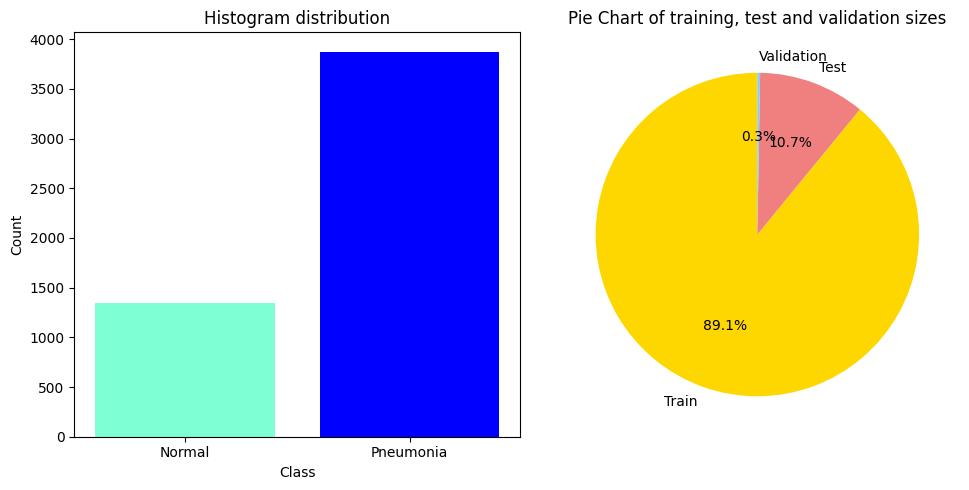


The number of training images: 5216
The number of test images: 624
The number of validation images: 16


In [136]:
# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Counting the Normal and Pneumonia images in the training set
train_norm, train_pneu = counter(path_training_set, labels = True); # Count the number of normal images and pneumonia images

train_num = counter(path_training_set, labels = False);
test_num = counter(path_test_set, labels = False);
val_num = counter(path_val_set, labels = False);

# Histogram Data
classes_hist = ['Normal', 'Pneumonia']
counts_hist = [train_norm, train_pneu]
colors_hist = ['aquamarine', 'blue']

# Pie Chart Data
classes_pie = ['Train', 'Test', 'Validation']
counts_pie = [train_num, test_num, val_num]
colors_pie = ['gold', 'lightcoral', 'lightskyblue']

# Create a figure with specific dimensions and subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize as needed

# Plotting the histogram
ax[0].bar(classes_hist, counts_hist, color=colors_hist)
ax[0].set_title('Histogram distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')

# Plotting the pie chart
ax[1].pie(counts_pie, labels=classes_pie, colors=colors_pie, autopct='%1.1f%%', startangle=90)
ax[1].set_title('Pie Chart of training, test and validation sizes')

plt.tight_layout()  # This adjusts subplot params so that the subplots fit into the figure area.
plt.show()

print("\nThe number of training images:", train_num)
print("The number of test images:", test_num)
print("The number of validation images:", val_num)



# PREPROCESSING

In this part we will do some preprocessing techinique on the data:

1. Data

## Visualization of two random images

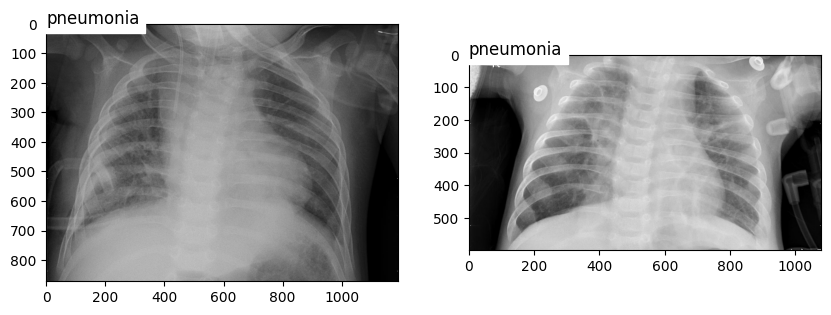

The shape of the first image is:  torch.Size([872, 1192, 3])
The shape of the second image is:  torch.Size([600, 1080, 3])


In [137]:
# Define a transform element to resize the images as square images and transform in Tensor
tr_1 = transforms.ToTensor()                # Convert the image to a tensor

# Definition of the paths for training, test and validation set
path_training_set = "/content/chest_xray/train"
path_test_set = "/content/chest_xray/test"
path_val_set = "/content/chest_xray/val"

# Instance of classes for the Dataset
train_dataset = ChestRayDataset(path_training_set, tr_1) # Create an instance of training class
test_dataset = ChestRayDataset(path_test_set, tr_1) # Create an instance of test class
val_dataset = ChestRayDataset(path_val_set, tr_1) # Create an instance of validation class

# Generate two random numbers to select two random images from training set
random_num_1 = np.random.randint(1, len(train_dataset))
random_num_2 = np.random.randint(1, len(train_dataset))

# Take an image + label randomly
img_1, label_1 = train_dataset[random_num_1]
img_2, label_2 = train_dataset[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)

## Squarring

In [138]:
size = (800,800) # Choose the size
mode = 'bilinear' # Choose the mode of interpolation ('nearest', 'bilinear', 'bicubic', ...)

resize_and_save(mode=mode, size=size)

Data for train already resized 
Data for test already resized 
Data for val already resized 


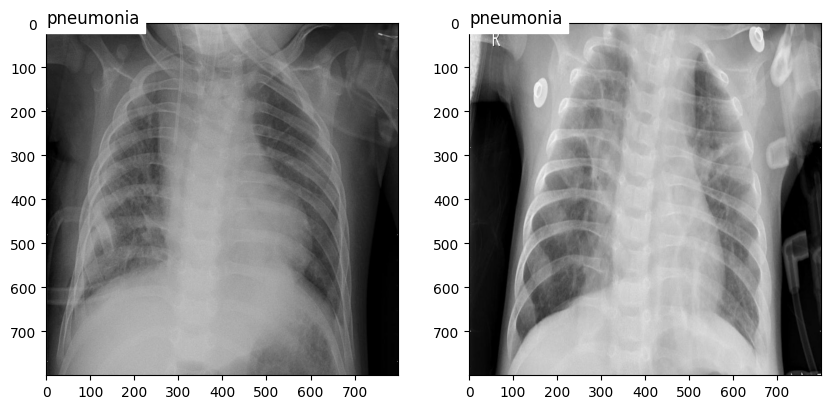

The shape of the first image is:  torch.Size([800, 800, 3])
The shape of the second image is:  torch.Size([800, 800, 3])


In [139]:
# Define a transform element to resize the images as square images and transform in Tensor
tr_1 = transforms.ToTensor()                 # Convert the image to a tensor

# Definition of the paths for training, test and validation set
path_training_set_resized = "/content/chest_xray_resized/train"
path_test_set_resized = "/content/chest_xray_resized/test"
path_val_set_resized = "/content/chest_xra_resized/val"

# Instance of classes for the Dataset
train_dataset_resized = ChestRayDataset(path_training_set_resized, tr_1) # Create an instance of training class
test_dataset_resized = ChestRayDataset(path_test_set_resized, tr_1) # Create an instance of test class
val_dataset_resized = ChestRayDataset(path_val_set_resized, tr_1) # Create an instance of validation class

# Take an image + label randomly
img_1, label_1 = train_dataset_resized[random_num_1]
img_2, label_2 = train_dataset_resized[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)



## DATA AUGMENTATION

https://pytorch.org/vision/stable/transforms.html

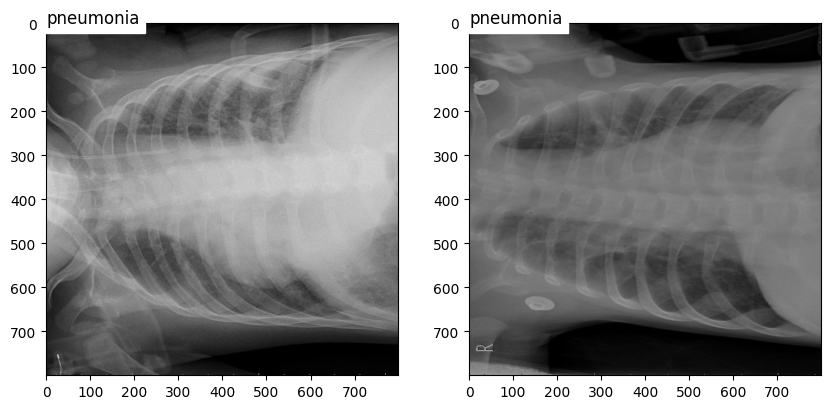

The shape of the first image is:  torch.Size([800, 800, 3])
The shape of the second image is:  torch.Size([800, 800, 3])


In [140]:
tr_augmentation = transforms.Compose([
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(0.8),
     transforms.RandomVerticalFlip(0.2),
     transforms.ColorJitter(brightness=0.4),
     transforms.RandomRotation(degrees=(90,90)),
])

# Instance of classes for the Dataset
train_dataset_resized = ChestRayDataset(path_training_set_resized, tr_augmentation) # Create an instance of training class

# Take an image + label randomly
img_1, label_1 = train_dataset_resized[random_num_1]
img_2, label_2 = train_dataset_resized[random_num_2]

# Display the image using matplotlib library
plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_1.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_1, fontsize=12, color='black', backgroundcolor='white')

plt.subplot(1,2,2)
plt.imshow(img_2.permute(1, 2, 0))
plt.axis('on')
plt.text(0, 0, label_2, fontsize=12, color='black', backgroundcolor='white')

plt.show()

print ("The shape of the first image is: ", img_1.permute(1, 2, 0).shape)
print ("The shape of the second image is: ", img_2.permute(1, 2, 0).shape)


## PREPROCESSING

In [141]:
tr_augmentation = transforms.Compose([
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(0.8),
     transforms.RandomVerticalFlip(0.2),
     transforms.ColorJitter(brightness=0.4),
     transforms.RandomRotation(degrees=(90,90)),
])

## SETUP DEVICE

In [142]:
setup_device()

Current device: cpu


normal


(-0.5, 1807.5, 1541.5, -0.5)

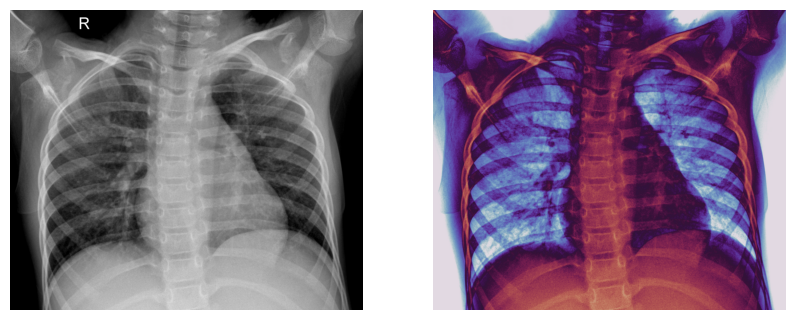

In [143]:
normal_img, label_1  = train_dataset[97] #"chest_xray/test/train_normal_00001.jpeg"
print(label_1)
print(normal_img.shape)

processed_img = get_heatmap(normal_img)

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow( np.transpose(normal_img, (1,2,0)), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')

normal
torch.Size([3, 1059, 1442])


(-0.5, 1441.5, 1058.5, -0.5)

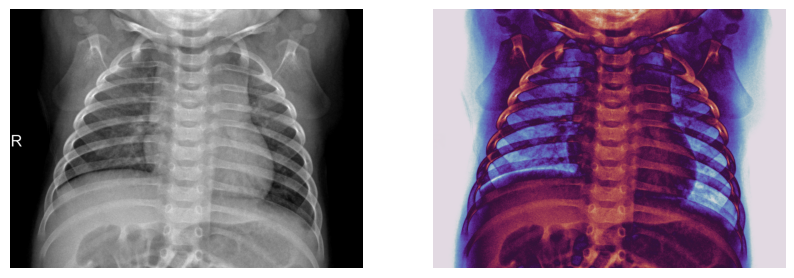

In [144]:
normal_img, label_2  = train_dataset[13] # "chest_xray/test/test_pneumonia_00019.jpeg"
print(label_2)
print(normal_img.shape)

processed_img = get_heatmap(normal_img)

plt.figure( figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.transpose(normal_img, (1,2,0)), cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(processed_img)
plt.axis('off')